In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.output_layer = nn.Linear(input_size + hidden_size, output_size)
        self.hidden_layer = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1) 
        
    def forward(self, input_tens, hidden_tens):
        combined = torch.cat((input_tens, hidden_tens), 1)
        
        hidden = self.hidden_layer(combined)
        hidden = self.relu(hidden)
        
        out = self.output_layer(combined)
        out = self.softmax(out) 
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
#Setup Globals
WORD_COUNT = 316
CATEGORY_COUNT = 2 #Positive or Negative
WORD_DICT = {}
CATEGORY_DICT = {0: "Negative", 1: "Positive"}

vocab = pd.read_csv("data/dictionary.txt")
for i in range(WORD_COUNT):
    word = vocab["Word"][i]
    word_id = vocab["Id"][i]
    WORD_DICT[word] = word_id

In [4]:
def tokenize_input(sentence):
    token_list = []
    word = ""
    punctuation = [".", "!", "?"]
    for char in sentence:
        if char == " ":
            token_list.append(word)
            word = ""
        elif char in punctuation:
            token_list.append(word)
            word = ""
            word += char
        else:
            word += char
    token_list.append(word)
    return token_list

def load_data():
    train = pd.read_csv("data/train.txt")
    test = pd.read_csv("data/test.txt")
    return train, test


def sentence_to_tensor(sentence):
    tokens = tokenize_input(sentence)
    tensor = torch.zeros(len(tokens), 1, WORD_COUNT)
    for i, word in enumerate(tokens):
        tensor[i][0][WORD_DICT[word]] = 1
    return tensor

def category_to_tensor(sentiment):
    if sentiment == "Positive":
        return torch.tensor([1], dtype=torch.long)
    else:
        return torch.tensor([0], dtype=torch.long)
    

def get_random_row(df):
    row_count = df.shape[0]
    rand_ind = random.randrange(row_count)
    x = df["Sentence"][rand_ind]
    y = df["Sentiment"][rand_ind]
    return x, y
   
def train_sentence(sentence_tensor, category_tensor):
    hidden = rnn_model.init_hidden()
    
    for i in range(sentence_tensor.size()[0]):
        output, hidden = rnn_model(sentence_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def convert_output(output_tensor):
    key = torch.argmax(output).item()
    return CATEGORY_DICT[key]
    

In [5]:
train, test = load_data()

In [6]:
n_hidden = 256

rnn_model = RNN(WORD_COUNT, n_hidden, CATEGORY_COUNT)

In [7]:
learning_rate = 0.005
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=learning_rate)


In [8]:
epoch_count = 5
loss_sum = 0
all_losses = []
plot_step, print_step = 200, 5000
n_iter = 15000
for i in range(n_iter):
    x, y = get_random_row(train)
    x_tensor = sentence_to_tensor(x)
    y_tensor = category_to_tensor(y)
    output, loss = train_sentence(x_tensor, y_tensor)
    loss_sum += loss
    
    if(i+1) % plot_step == 0:
        all_losses.append(loss_sum/plot_step)
        loss_sum = 0
        
    if (i+1) % print_step == 0:
        guess = convert_output(output)
        correct = "CORRECT" if guess == y else f"WRONG, Actual Category ({y})"
        print(f" iteration={i+1} percent_done={(i+1)/n_iter*100}% loss={loss:.4f} Last Sample Result: {x} / {guess} {correct}")
        

 iteration=5000 percent_done=33.33333333333333% loss=0.0731 Last Sample Result: Ha! You think I care about you? What do you think I am desperate? / Negative CORRECT
 iteration=10000 percent_done=66.66666666666666% loss=0.0486 Last Sample Result: You’re a monster. / Negative CORRECT
 iteration=15000 percent_done=100.0% loss=0.0000 Last Sample Result: You’re the worst mistake I’ve ever made. / Negative CORRECT


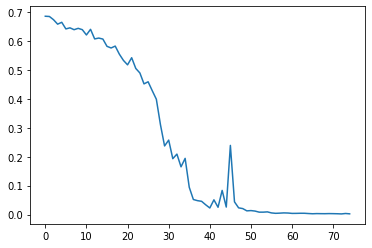

In [9]:
plt.plot(all_losses)
plt.show()

In [10]:
y_tars = []
y_preds = []
sentences = []
for i in range(test.shape[0]):
    x, y = test["Sentence"][i], test["Sentiment"][i]
    y_tars.append(y)
    sentences.append(x)
    x_tensor = sentence_to_tensor(x)
    hidden_tens = rnn_model.init_hidden()
    with torch.no_grad():
        for j in range(x_tensor.size()[0]):
            output, hidden_tens = rnn_model(x_tensor[j], hidden_tens)
        y_pred = convert_output(output)
        y_preds.append(y_pred)
        


In [11]:
results = pd.DataFrame({"Sentence": sentences, "Prediction":y_preds, "Target":y_tars})

In [12]:
results

,Sentence,Prediction,Target
0,You are my most favorite part of reality.,Positive,Positive
1,My dream is to be with you forever.,Positive,Positive
2,You always make me want to cuddle with you.,Positive,Positive
3,You being happy makes me happy.,Positive,Positive
4,You are the most amazing person I have ever kn...,Positive,Positive
5,Some people are just born to fail. Sorry you’r...,Negative,Negative
6,You’re so worthless you hardly even exist to me.,Negative,Negative
7,I wish I could go back to the day I met you an...,Negative,Negative
8,If you give me that look one more time I’m ski...,Negative,Negative
9,Honestly I’m embarrassed to even know you...,Positive,Negative


In [13]:
results["Sentence"][4]

'You are the most amazing person I have ever known.'

In [14]:
results["Sentence"][9]

'Honestly I’m embarrassed to even know you...'

In [15]:
from sklearn.metrics import precision_recall_fscore_support
scores = precision_recall_fscore_support(y_tars, y_preds)

In [16]:
precision = scores[0][0]
recall = scores[1][0]
f1 = scores[2][0]

In [17]:
print("Positive Class Metric Report on Test Set")
print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

Positive Class Metric Report on Test Set
Precision=1.0000, Recall=0.8000, F1=0.8889


In [18]:
#The scores are high but to be fair our dataset is incredibly small and is not representative of all possible positive
#and negative phrases. Under this limited scope it does well but this is purely to practice and learn not to create a 
#useful model